# Tutorial estimación de esfuerzo utilizando Probe

## Cómo usar este tutorial

- Esta es su copia de trabajo, por favor lea los textos para seguir el tutorial.
- Para ejecutar una celda con código, párese en la misma y presione el botón *Run* en la parte superior. Los cálculos se deben ir ejecutando en la secuencia que está definida en el documento. 
- Puede usar la opción Kernel->Restart para reiniciar su notebook.
- Puede realizar modificaciones si quiere realizar pruebas.

## Objetivos del tutorial

En este  tutorial utilizaremos el método de Probe (Proxy based estimation) para estimar el esfuerzo necesario, medido en horas de trabajo, para desarrollar una aplicación utilizando datos históricos y para analizar si los datos históricos son adecuados para el cálculo de la regresión.

Los pasos que seguiremos son: 
1. Crear la gráfica de dispersión de los datos históricos. 
2. Calcular algunas estadisticas básicas a partir de los datos históricos.
3. Calcular la regresión lineal con base en los históricos.
4. Estimar el esfuerzo de un proyecto utilizando la regresión lineal.
5. Calcular los intervalos de confianza de la estimación.

_____
Este tutorial ha sido desarrollado en la Universidad de los Andes, Colombia


In [1]:
# Importar las librería que se requieren para realizar el ejercicio
import pandas as pd
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Markdown, Latex

plt.rcParams["figure.figsize"]=10,7

### Datos históricos
Vamos a suponer que tenemos los siguientes datos históricos de proyectos anteriores. En la primera columna se encuentra el código proyecto; en la columna LOCs totales (X) se presenta el tamaño real en líneas de código (LOCs) que incluye LOCs de typescript, html, css y, en columna Tiempo real (Y) se presenta el tiempo total invertido para desarrollar el proyecto. Estel tiempo suma todas las actividades del proyecto de cada una de las iteraciones realizadas incluyendo requisitos, diseños, codificación, entrega, pruebas, etc. Se incluye el tiempo de las primeras 5 entregas a producción; los proyectos se siguen manteniendo y actualizando. 

La siguiente instrucción carga y muestra la lista de datos, contenidos en el archivo *datos_tutorial.csv*:

In [2]:
# Leer los datos históricos
datos = pd.read_csv("datos_tutorial.csv")
datos

,LOCs Totales,Tiempo Real
0,209732,19440
1,233456,25600
2,223984,22400
3,256000,36800
4,275670,42000
5,300458,61520
6,324897,71480


### Características de los proyectos

Los proyectos en la tabla anterior tienen las siguientes características:

- Corresponden a aplicaciones web desarrolladas en Angular. 
- El equipo de desarrollo varía entre 5 y 10 desarrolladores. 
- La estabilidad de los requisitos fue alta y similar entre los proyectos.  
- En todo los casos se desarrolló utilizando integración continua. El proceso de desarrollo es bien conocido por los desarrolladores
- El equipo tiene experiencia en proyectos similares


## 1. Crear la gráfica de dispersión

La siguiente figura nos muestra la dispersión de los puntos en el plano cartesiano. El eje x corresponde a los datos de tamaño de los proyectos medidos en líneas de código LOCs. El eje y correspode a los datos del esfuerzo invertido en los proyectos medido en Horas. 

Es importante identificar en la gráfica si los puntos, que corresponden a datos históricos reales de proyectos, se aproximan a una línea recta o no. En este caso, podemos observar que estos puntos tienden a una línea recta. 
Esto se debe a que los proyectos tuvieron unas características muy similares lo que hace que podamos obviar otros factores de complejidad en el desarrollo de tal forma que el tamaño del proyecto y el esfuerzo estpán relacionados de forma lineal.

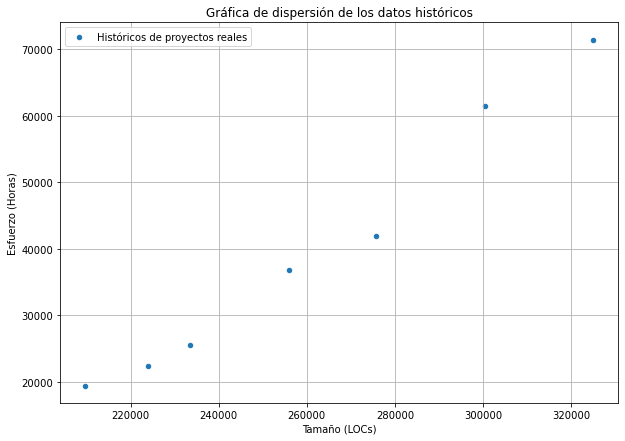

In [3]:
# 1. Crear la gráfica de dispersión de los datos históricos

ax = datos.plot.scatter(x='LOCs Totales', y='Tiempo Real', label='Históricos de proyectos reales')
ax.set_xlabel('Tamaño (LOCs)')
ax.set_ylabel('Esfuerzo (Horas)')
plt.title("Gráfica de dispersión de los datos históricos")
plt.legend()
plt.grid(True)
plt.show()

## 2. Calcular estadísticas básicas sobre la muestra

Antes de continuar vamos a calcular algunas estadísticas básicas, necesarias para el cálculo de la regresión lineal. La siguiente tabla presenta:
- El tamaño de la muestra es 7. 
- Promedio del tamaño (LOCs) y del Esfuerzo (Tiempo Real)
- Desviación estándar del tamaño (LOCs) y del Esfuerzo (Tiempo Real)
...


In [4]:
# 2. Calcular algunas estadisticas básicas a partir de los datos históricos.
# Calcula el promedio (mean), la desviación estándar (std), mínimo (min), 
# el valor al 25%, 50% y 75% de la normal y el máximo (máx). 
# Los cálculos se realizan tanto para el tamaño como para el esfuerzo.

datos.describe()

,LOCs Totales,Tiempo Real
count,7.000000,7.000000
mean,260599.571429,39891.428571
std,42103.267664,20033.687819
min,209732.000000,19440.000000
25%,228720.000000,24000.000000
50%,256000.000000,36800.000000
75%,288064.000000,51760.000000
max,324897.000000,71480.000000


Con la siguiente instrucción calculamos la varianza

In [5]:
# Calcular varianza
datos.var()

LOCs Totales    1.772685e+09
Tiempo Real     4.013486e+08
dtype: float64

Con la siguiente instrucción calculamos la covarianza entre el tamaño y el esfuerzo:

In [6]:
# Calcular covarianza
datos.cov()

,LOCs Totales,Tiempo Real
LOCs Totales,1.772685e+09,8.346391e+08
Tiempo Real,8.346391e+08,4.013486e+08


## 3. Calcular la regresión lineal 

La fórmula de la regresión lineal es la siguiente:

$ Y = b_0 + b1 * X$

En nuestro caso, *Y* corresponde al **Esfuerzo en Horas** y *X* corresponde al **Tamaño en LOCs**. 
En la fórmula, $b_0$ y $b_1$ son dos constantes, la primera es el valor de $Y$ cuando $X$ vale $0$ y la segunda la pendiente de la línea, que se calculan con las siguientes fórmulas:

$b_0 = \frac{covarianza}{varianza X}$

$b_1 = mean \cdot Y - B_0 \cdot mean X$

In [7]:
# 3. Calcular la regresión lineal con base en los históricos.

regresion = stats.linregress(datos['LOCs Totales'], datos['Tiempo Real'])

display(Markdown("El valor de $R^2$ de nuestra regresión es de ${:.5f}$".format(regresion.rvalue)))
display(Markdown("El valor de $b_0$ (intercepto) de nuestra regresión es de ${:.2f}$".format(regresion.intercept)))
display(Markdown("El valor de $b_1$ (pendiente) de nuestra regresión es de ${:.2f}$".format(regresion.slope)))

El valor de $R^2$ de nuestra regresión es de $0.98951$

El valor de $b_0$ (intercepto) de nuestra regresión es de $-82807.52$

El valor de $b_1$ (pendiente) de nuestra regresión es de $0.47$

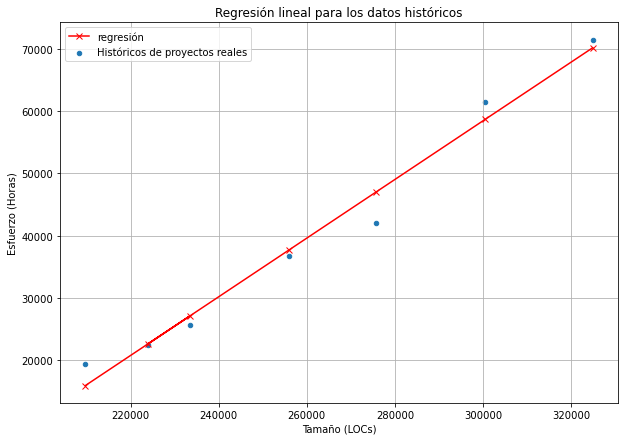

In [8]:
# Grafica la línea que representa la regresión lineal. 

ax = datos.plot.scatter(x='LOCs Totales', y='Tiempo Real', label='Históricos de proyectos reales')

plt.plot(datos['LOCs Totales'], regresion.intercept+(regresion.slope*datos['LOCs Totales']),'r', label='regresión', marker='x')
ax.set_xlabel('Tamaño (LOCs)')
ax.set_ylabel('Esfuerzo (Horas)')

plt.title("Regresión lineal para los datos históricos")

plt.legend()
plt.grid(True)

## 4. Estimar el esfuerzo de un proyecto




In [9]:
# 4. Estimar el esfuerzo de un proyecto utilizando la regresión lineal.
# Vamos a suponer que tenemos, para un nuevo proyecto, una estimación de tamaño de 289700 LOCs

X= 289700

display(Markdown('Supongamos  que tenemos un estimado de tamaño de ${}$ LOCs. Utilizando la regresión lineal que calculamos podemos determinar el esfuerzo:'\
                 .format(X)))

Esfuerzo = regresion.intercept+regresion.slope*X
display(Markdown('Con el tamaño estimado dado de  $X={}$ el esfuerzo utilizando la regresión lineal es $Y={:.2f} Horas$'\
                 .format(X, Esfuerzo)))

display(Markdown('Transformando el valor anterior a persona-mes (con un número de horas efectivas al mes de 140) obtenemos un esfuerzo total de ${:.2f}$ Persona-mes'\
                 .format(Esfuerzo/140)))


Supongamos  que tenemos un estimado de tamaño de $289700$ LOCs. Utilizando la regresión lineal que calculamos podemos determinar el esfuerzo:

Con el tamaño estimado dado de  $X=289700$ el esfuerzo utilizando la regresión lineal es $Y=53592.88 Horas$

Transformando el valor anterior a persona-mes (con un número de horas efectivas al mes de 140) obtenemos un esfuerzo total de $382.81$ Persona-mes

## 5. Calcular el intervalo de confianza

El intervalo de confianza nos dice que tan bueno es nuestro estimado o, dicho de otra forma, que tan buenos son nuestros datos históricos. 

El intervalo de confianza nos dice, para una probabilidad dada, cuál es el límite superior y el límite inferior de que la respuesta real ese en ese intervalo: 

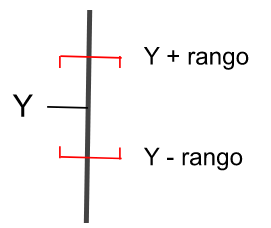

El valor del límite superior corresponde al punto Y sumado el rango y el del límite inferior al punto Y menos el rango. 

El intervalo de confianza  nos mejora la respuesta del estimado de la siguiente forma:

Con una probabilidad del $95%$ el valor real del estimado caerá en el siguiente intervalo: [Y + rango, Y - rango]

Por ejemplo, para el cálculo anterior donde:

$Y = 53592.88 Horas$

Si el rango fuera = 2000 horas, la respuesta completa sería: 

El estimado es $53592.88$ Horas más o menos $2000$ horas con una probabilidad del $95\%$


Para definir el intervalo de confianza, debemos precisar la probabilidad con la que queremos quedar allí. Para esto se utiliza la  distribución t de Student que se utiliza para resolver problemas de intervalos de confianza. Se trata de una distribución de probabilidad que permite estimar la media de una población con distribución normal, pero con un tamaño de muestra pequeño.
Calculamos el intervalo de confianza a partir del error estándar y la distribución t estudiante.

Vamos a usar la siguiente fórmula:


$ \LARGE\hat{y} {\displaystyle \pm } t_{(1-\alpha/2,n-2)} \sqrt{\frac{\sum_{i=1}^{n}(y_i-\hat{y_i})^2}{n-2}(1+\frac{1}{n}+\frac{(x-\hat{x})^2}{\sum_{i=1}^{n}(x_i-\bar{x_i})^2})} $

En donde

$\LARGE t_{(1-\alpha/2,n-2)}$

Es la distribución t Student para una confianza 1-$\alpha$. Vamos a calcular entonces este valor con $95%$ de confianza.

In [10]:
confianza = 0.95
t_probabilidad = stats.t.ppf(1-((1-confianza)/2), df=len(datos)-2)
t_probabilidad

2.5705818366147395

La siguiente parte de la ecuación consiste en:

$\LARGE\sigma =  \sqrt{\frac{\sum_{i=1}^{n}(y_i-\hat{y_i})^2}{n-2}}$

Lo que es el error estándar de la predicción.

In [11]:
error_estandar = (sum((datos['Tiempo Real'] - ( regresion.intercept+(regresion.slope*datos['LOCs Totales'])))**2) / (len(datos)-2))**0.5

display(Markdown('El error estándar de la predicción es de {:.4f}'.format(error_estandar)))

El error estándar de la predicción es de 3169.7572

Luego tenemos el término:

$\LARGE\frac{(x-\hat{x})^2}{\sum_{i=1}^{n}(x_i-\bar{x_i})^2}$

En donde $x$ es el valor de las LOC para el que prediremos cosas (en este caso uno), $x_i$ es cada uno de los valores con el que ajustamos la predicción y $\bar{x_i}$ es la media de dichos valores de LOC.

In [12]:
x_distancia = datos['LOCs Totales'] - datos['LOCs Totales'].mean()
E = (((X-datos['LOCs Totales'].mean())**2)/( np.square(x_distancia).sum() ))



Finalmente reemplazamos todo en la ecuación

In [13]:
tamanio_intervalo = t_probabilidad*error_estandar*np.sqrt(1+(1/len(datos))+E) 

display(Markdown('El tamaño de nuestro intervalo es de {:.2f}'.format(tamanio_intervalo)))

El tamaño de nuestro intervalo es de 9009.02

Lo que significa que nuestro intervalo será:

In [14]:
intervalo = (Esfuerzo-tamanio_intervalo, Esfuerzo+tamanio_intervalo)

display(Markdown('Nuestro intervalo será entonces $({:.2f},{:.2f})$ con un ${}\%$ de confianza'.format(intervalo[0],intervalo[1], confianza*100)))

Nuestro intervalo será entonces $(44583.86,62601.90)$ con un $95.0\%$ de confianza

Finalmente vamos entonces a pintar nuestra regresión, los datos reales y el intervalo de confianza.

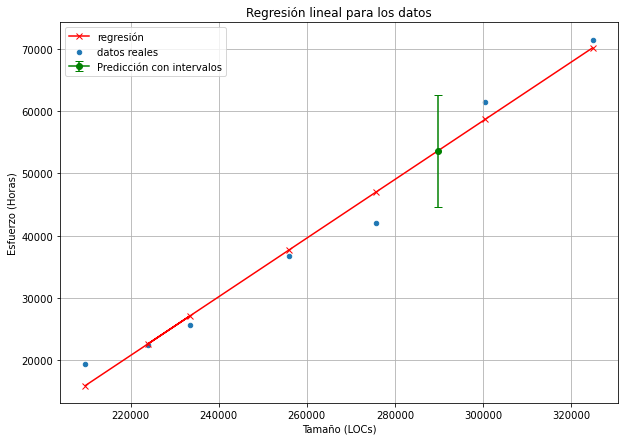

In [15]:
ax = datos.plot.scatter(x='LOCs Totales', y='Tiempo Real', label='datos reales')
ax.set_xlabel('Tamaño (LOCs)')
ax.set_ylabel('Esfuerzo (Horas)')


plt.rcParams["figure.figsize"]=10,7
plt.plot(datos['LOCs Totales'], regresion.intercept+(regresion.slope*datos['LOCs Totales']),'r', label='regresión', marker='x')

plt.errorbar(X, Esfuerzo, yerr=tamanio_intervalo,capsize=4, color='g', marker='o', label='Predicción con intervalos')

plt.title("Regresión lineal para los datos")
plt.legend()
plt.grid(True)
plt.show()

## Conclusión

In [16]:
display(Markdown("En conclusión, para el proyecto cuya estimación de tamaño en líneas de código es *{} LOCs*, la estimación del esfuerzo es de *{:.2f}* 𝐻𝑜𝑟𝑎s.".format(X, Esfuerzo)))
display(Markdown("Esta respuesta de esfuerzo estimado puede variar entre *{:.2f} y {:.2f}*  con un {}% de confianza.".format(intervalo[0],intervalo[1], confianza*100)))
display(Markdown("Este intervalo corresponde a una diferencia de más o menos el {0:.1f}% del valor estimado lo que nos lleva a concluir que, si las caracteristicas del nuevo proyecto son similares a las de los proyectos en los datos históricos, el estimado es bastante bueno porque el error será solo del {0:.1f}.".format(100-(intervalo[0]*100/Esfuerzo))))

En conclusión, para el proyecto cuya estimación de tamaño en líneas de código es *289700 LOCs*, la estimación del esfuerzo es de *53592.88* 𝐻𝑜𝑟𝑎s.

Esta respuesta de esfuerzo estimado puede variar entre *44583.86 y 62601.90*  con un 95.0% de confianza.

Este intervalo corresponde a una diferencia de más o menos el 16.8% del valor estimado lo que nos lleva a concluir que, si las caracteristicas del nuevo proyecto son similares a las de los proyectos en los datos históricos, el estimado es bastante bueno porque el error será solo del 16.8.

## Referencias
[1] Watts S. Humphrey. A Discipline for Software Engineering. Addison-Wesley, 1995. Recurso electrónico disponible en la base de datos de O´Reilly de la biblioteca.uniandes.edu.co 
 
[2] Barry W. Boehm, Chris Abts, A. Winsor Brown, Bradford K. Clark, Sunita Chulani. Software Cost Estimation with COCOMO II. Prentice Hall, 2009. Recurso electrónico disponible en la base de datos de O´Reilly de la biblioteca.uniandes.edu.co 
